## Smart Voice Assistant For The Blind

Setting Up Colab and Importing Modules

In [ ]:
# Mounting google drive into colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Setting up the Kaggle Setup
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/kaggle_dataset'

In [ ]:
#Go to the folder
%cd /content/gdrive/MyDrive/kaggle_dataset

/content/gdrive/MyDrive/kaggle_dataset


In [ ]:
#Setting up the BASE and the WORKING Directories
BASE_DIR = '/content/gdrive/MyDrive/kaggle_dataset'
WORKING_DIR = '/content'

In [ ]:
#Importing the necessary modules
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
# Loading the VGG16
model = VGG16()

#Changing the model: Removing the predicted values from the existing VGG16 model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [ ]:
# Extracting the features into features array
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for i in tqdm(os.listdir(directory)):
    img_path = directory + '/' + i
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = i.split('.')[0]
    features[image_id] = feature


# Dumping the features array into a pickle file
pickle.dump(features, open(os.path.join(BASE_DIR, 'features.pkl'), 'wb'))

  0%|          | 0/8092 [00:00<?, ?it/s]

In [ ]:
# load features from the saved pickle file
with open(os.path.join(BASE_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
# Reading the descriptions.txt file
with open(os.path.join(BASE_DIR, 'descriptions.txt'), 'r') as f:
    next(f)
    desc_doc = f.read()

In [ ]:
#Mapping the descriptions to the images
mapping = {}
for each_desc in tqdm(desc_doc.split('\n')):
    tokens = each_desc.split(',')
    if len(each_desc) < 2:
        continue
    image_id, desc_of = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    desc_of = " ".join(desc_of)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(desc_of)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
# Editing the descriptions: Convert to lower case and add beginning and ending
def edit_description(mapping):
    for key, desc in mapping.items():
        for i in range(len(desc)):
            x = desc[i]
            x = x.lower()
            x = x.replace('[^A-Za-z]', '')
            x = x.replace('\s+', ' ')
            x = 'beginning ' + " ".join([word for word in x.split() if len(word)>1]) + ' ending'
            desc[i] = x

In [ ]:
# Calling the preprocessing text function
edit_description(mapping)

In [ ]:
# Appending all descriptions into a list: Each image with 5 descriptions
img_desc = []
for key in mapping:
    for caption in mapping[key]:
        img_desc.append(caption)

In [ ]:
# Tokenizing the text: finding the unique words from all the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(img_desc)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
print("Unique words in the captions are: " + str(vocab_size))

Unique words in the captions are: 8484


In [ ]:
# Get the maximum description length for the padding required
max_length = max(len(text.split()) for text in img_desc)
max_length

35

In [ ]:
# Splitting the dataset into Training and Testing: 90% is given to training and remaining is for the test
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# Generating the data frm the inputs of images and descriptions and passing it for the model
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            text = mapping[key]
            for t in text:
                seq = tokenizer.texts_to_sequences([t])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# Giving the inputs for the CNN

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#Training the model with 20 epochs
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save(BASE_DIR+'/best_model.h5')

227/227 [==============================] - 81s 359ms/step - loss: 2.1697


In [ ]:
def mapping_toword(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_description(model, image, tokenizer, max_length):
    in_text = 'beginning'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        desc_predict = model.predict([image, sequence], verbose=0)

        desc_predict = np.argmax(desc_predict)
        word = mapping_toword(desc_predict, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'ending':
            break

    return in_text

In [ ]:
actual, predicted = list(), list()

for key in tqdm(test):
    desc = mapping[key]
    y_pred = predict_description(model, features[key], tokenizer, max_length)
    actual_desc = [caption.split() for text in desc]
    y_pred = y_pred.split()
    actual.append(actual_desc)
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_text(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    desc = mapping[image_id]
    y_pred = predict_description(model, features[image_id], tokenizer, max_length)
    plt.imshow(image)

    return str(y_pred)

In [ ]:
# Installing the required modules

!pip3 install gTTS pyttsx3 playsound pygobject

  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=93fa50600c54263fadddf1eb9c8f17ea0aae865ea30335ab02c9f3bbee0cc85b
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


Frames Have Been Stored




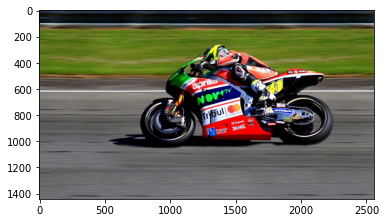

In [ ]:
# Video Input: Converting to frames and passing the frame to the generate text function

import cv2
import os
from google.colab.patches import cv2_imshow
from gtts import gTTS
from IPython.display import Audio

vid = cv2.VideoCapture('/content/gdrive/MyDrive/kaggle_dataset/Motorcycle.mp4')
currentFrame = 0

while(True):
  success,frame = vid.read()
  cv2.imwrite('/content/gdrive/MyDrive/kaggle_dataset/data/frame' + str(currentFrame) + '.jpg',frame)
  currentFrame+=1
  if(currentFrame>50):
    print("Frames Have Been Stored\n\n")
    break
  cv2.destroyAllWindows()

text = str(generate_text("frame45.jpg"))
res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]
tts = gTTS(text)
tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True)

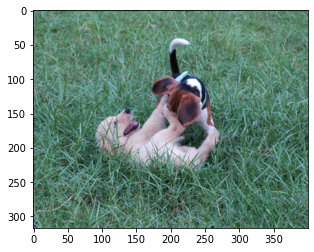

In [ ]:
from gtts import gTTS
from IPython.display import Audio

text = str(generate_text("23445819_3a458716c1.jpg"))

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text)

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True)

In [ ]:
# Setting up the engine for voice to text for input commands
import os
import speech_recognition as sr
import pyttsx3
import pyaudio

def voice_output(command):
    engine = pyttsx3.init()
    engine.say(command)
    engine.runAndWait()
r = sr.Recognizer()
x = 0

while(x == 0):
    try:
        with sr.Microphone() as source2:
            r.adjust_for_ambient_noise(source2, duration=0.2)
            voice_output("Listening.....")
            audio2 = r.listen(source2)
            MyText = r.recognize_google(audio2)
            MyText = MyText.lower()
            print("Speaker said: " + MyText)
            voice_output(MyText)
            if 'camera' in MyText:
                file_name = input("Enter the file name: ")
            x += 1
    except sr.RequestError as e:
        print("Error; {0}".format(e))
    except sr.UnknownValueError:
        print("Error")

Time taken for the processes:

1) To extract the features of all the images : 17 min       
2) To train the model (20 epochs): 31 min               
3) To get the description of an image: 2 seconds          
4) To get the description of a video: 21 seconds (Delay identified)